[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
NaN in data! Fixed.
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.28348061 0.93958657]
 ...
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.16723317 0.75616054]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.15778525, 0.15778525, 0.15169792, ..., 0.14207663, 0.14276837,
        0.14276837],
       [0.15778525, 0.15169792, 0.15169792, ..., 0.14276837, 0.14276837,
        0.13516649],
       [0.15169792, 0.15169792, 0.14621493, ..., 0.14276837, 0.13516649,
        0.13516649],
       ...,
       [0.79062285, 0.79780486, 0.79780486, ..., 0.75404546, 0.75404546,
        0.77007934],
       [0.79780486, 0.79780486, 0.79073449, ..., 0.75404546, 0.77007934,
        0.77007934],
       [0.79780486, 0.79073449, 0.79073449, ..., 0.77007934, 0.77007934,
        0.76770556]])

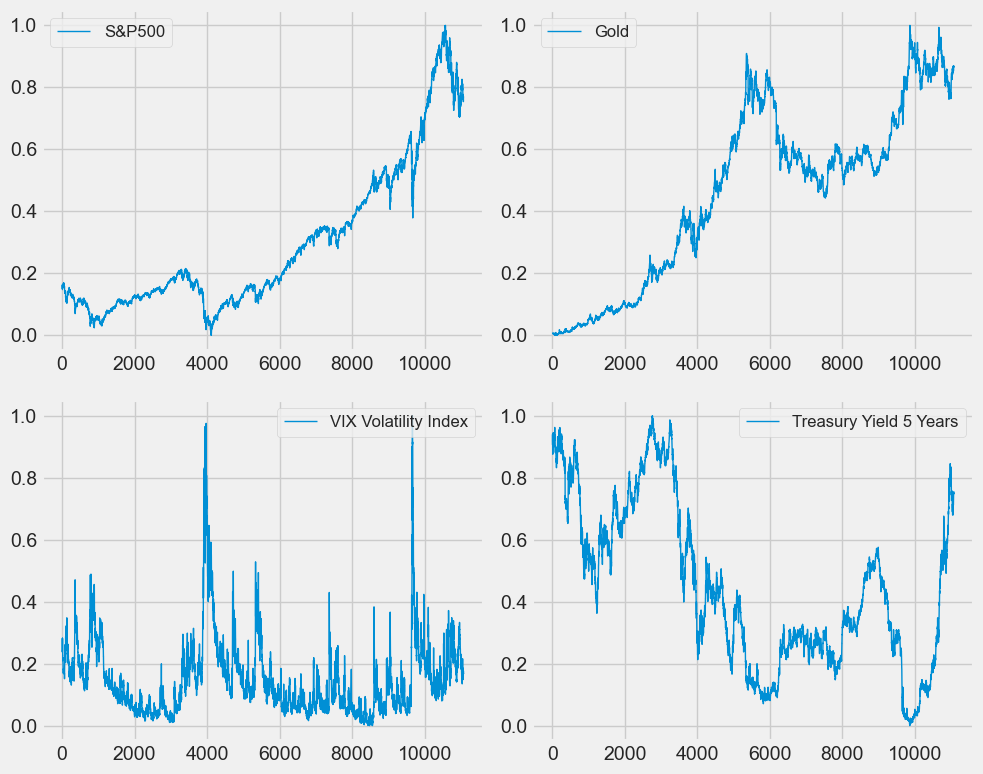

In [49]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass_module as dataclass_module
reload(dataclass_module)

input_length = 60
output_length = 30
output_steps_ahead = 1
database = dataclass_module.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [50]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

'''
class Stockdataset(Dataset):
    def __init__(self, data, input_length, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
'''
     
size_training = int(len(database.data_norm)*0.80)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = dataclass_module.Stockdataset(data_train, input_length, output_length)
test_dataset = dataclass_module.Stockdataset(data_test, input_length, output_length)
whole_dataset = dataclass_module.Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[0].shape)
print(whole_dataset.__getitem__(0)[0].shape)

training_batch_size = 513; #513
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current selected device
    device = torch.device('cuda')

    # Calculate memory details (in bytes)
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    available_memory = total_memory - allocated_memory

    # Convert bytes to GB
    total_memory_GB = total_memory / (1024 ** 3)
    allocated_memory_GB = allocated_memory / (1024 ** 3)
    available_memory_GB = available_memory / (1024 ** 3)

    print(f"Total memory on GPU: {total_memory_GB} GB")
    print(f"Allocated memory on GPU: {allocated_memory_GB} GB")
    print(f"Available memory on GPU: {available_memory_GB} GB")

    # If available memory is less than 2GB, use CPU
    if available_memory_GB < 2:
        device = torch.device('cpu')

else:
    # If CUDA is not available, use CPU
    device = torch.device('cpu')

print(f"Using device: {device}")



(8858, 4)
(2215, 4)
torch.Size([60, 4])
torch.Size([60, 4])
torch.Size([60, 4])
Total memory on GPU: 5.99957275390625 GB
Allocated memory on GPU: 0.19880056381225586 GB
Available memory on GPU: 5.800772190093994 GB
Using device: cuda


In [51]:
import utils.loss_module as loss_module
reload(loss_module)

loss_fun_con = nn.MSELoss()
loss_fun_member = nn.CrossEntropyLoss()
loss_fun_centers = nn.MSELoss()
loss_fun_recon = nn.MSELoss()
loss_fun_assign = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_balance = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_Kmeans = loss_module.KMeansClusteringLoss()
loss_fun_local = loss_module.LocalityPreservingLoss()
loss_fun_DQA = loss_module.QuadraticDiscriminantAnalysis()
loss_fun_GMM = loss_module.GaussianMixtureLoss()
loss_fun_FCM = loss_module.FuzzyCMeansClusteringLoss()
loss_fun_overlap = loss_module.OverlappingLoss()
loss_fun_ContrastiveLoss = loss_module.FuzzyContrastiveLoss(0.2)
loss_fun_FuzzyCMeansLossWithPenalties = loss_module.FuzzyCMeansLossWithPenalties()
loss_fun_TotalVariationLoss = loss_module.TotalVariationLoss()
loss_fun_orthogonality_penalty = loss_module.OrthogonalityLoss()
loss_fun_EntropyLoss = loss_module.EntropyLoss(1)
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture


In [52]:
from utils import display_module
reload(display_module)
from utils import checks_module
reload(checks_module)

import models.evolving_system_module as evolving_system_module
reload(evolving_system_module)
import models.feed_forward_module as feed_forward_module
reload(feed_forward_module)

import models.LSTM_encoder_module as LSTM_encoder_module
reload(LSTM_encoder_module)

<module 'models.LSTM_encoder_module' from 'C:\\Users\\Miha\\OneDrive - Univerza v Ljubljani\\Doktorski_studij\\Delo\\Evolving transformer\\models\\LSTM_encoder_module.py'>

In [53]:
'''
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1):
        super(MultiheadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.sequence_length = sequence_length
        self.msa = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)  # Added dropout after MultiheadAttention
        self.ff_ant = feed_forward_module.FeedForward(embed_dim, embed_dim, embed_dim)
        self.dropout2 = nn.Dropout(dropout_rate)  # Added dropout after FeedForward
       

        self.fc_query = nn.Linear(embed_dim, embed_dim)
        self.fc_key = nn.Linear(embed_dim, embed_dim)

        # Batch normalization layers
        #self.bn = nn.BatchNorm1d(sequence_length,track_running_stats = False)
        self.ln = nn.LayerNorm(embed_dim)


    def forward(self, x, attn_mask=None):
        query = self.fc_query(x)
        key = self.fc_key(x)

        x_att, weights = self.msa(query, key, key, attn_mask=attn_mask, need_weights=True, average_attn_weights=False)
        x_att = self.dropout1(x_att)  # Apply dropout after MultiheadAttention
        x_residual = self.ln(self.ff_ant(x_att) + x)
        x_residual = self.dropout2(x_residual)  # Apply dropout after FeedForward

        return x_residual, weights
        
'''

import math
import torch
from torch import nn

class MultiheadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1):
        super(MultiheadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        
        assert embed_dim % num_heads == 0
        
        # Define linear layers for the query, key, and value
        self.fc_query = nn.Linear(embed_dim, embed_dim)
        self.fc_key = nn.Linear(embed_dim, embed_dim)
        self.fc_value = nn.Linear(embed_dim, embed_dim)

        # Initialize weights using Kaiming (He) initialization
        #torch.nn.init.xavier_uniform_(self.fc_query.weight)
        #torch.nn.init.xavier_uniform_(self.fc_key.weight)
        #torch.nn.init.xavier_uniform_(self.fc_value.weight)
        torch.nn.init.kaiming_uniform_(self.fc_query.weight, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_uniform_(self.fc_key.weight, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_uniform_(self.fc_value.weight, nonlinearity='leaky_relu')

        # Optionally, initialize biases to zero
        torch.nn.init.zeros_(self.fc_query.bias)
        torch.nn.init.zeros_(self.fc_key.bias)
        torch.nn.init.zeros_(self.fc_value.bias)

        # Define the softmax layer
        self.softmax = nn.Softmax(dim=-1)

        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Define the output linear layer
        self.fc_out = nn.Linear(num_heads*embed_dim, embed_dim)

        # Define the layer normalization
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, x, attn_mask=None):
        batch_size = x.size(0)
        seq_length = x.size(1)

        # Create the query, key, and value matrices
        query = self.fc_query(x).view(batch_size, seq_length, self.num_heads, -1).transpose(1, 2)
        key = self.fc_key(x).view(batch_size, seq_length, self.num_heads, -1).transpose(1, 2)

        # Create a shared value matrix for all heads
        value = self.fc_value(x).view(batch_size, 1, seq_length, -1).expand(-1, self.num_heads, -1, -1)


        # Calculate the attention scores
        attn_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.embed_dim)

        # Apply the attention mask, if provided
        if attn_mask is not None:
            attn_scores = attn_scores.masked_fill(attn_mask == 0, float('-inf'))

        # Apply the softmax function to get the attention weights
        attn_weights = self.softmax(attn_scores)

        # Apply dropout
        if self.dropout_rate > 0.0:
            attn_weights = self.dropout(attn_weights)

        # Calculate the output tensor
        x_att = torch.matmul(attn_weights, value)
        x_att = x_att.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)

        # Pass the output tensor through the output linear layer
        x_att = self.fc_out(x_att)

        # Apply layer normalization
        x_residual = self.ln(x_att + x)

        return x_residual, attn_weights


class StackedAttentionNetwork(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, seq_length):
        super(StackedAttentionNetwork, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.att_layers = nn.ModuleList([
            #MultiheadSelfAttention(self.embed_dim, self.num_heads, batch_first=True)
            MultiheadSelfAttention(self.embed_dim, self.num_heads, dropout_rate=0.1)
            for _ in range(self.num_layers)
        ])

        
    def create_attention_mask(self, seq_length):
        # Create a 2D square matrix with seq_length dimensions.
        mask = torch.tril(torch.ones((seq_length, seq_length)), diagonal=-1)
        #mask = torch.triu(torch.ones((seq_length, seq_length)), diagonal=1)
        
        # Convert all values of 1 to -float('Inf') to prevent attending to future sequence elements.
        mask[mask == 1] = -float('Inf')

        return mask

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()
        all_att_weights = torch.empty((self.num_layers, self.num_heads, seq_length, seq_length))
        # Create attention mask and move it to the same device as x
        attn_mask = self.create_attention_mask(seq_length).to(x.device)
        for layer_idx in range(self.num_layers):
            att_layer = self.att_layers[layer_idx]
            x, att_weights = att_layer(x) #att_layer(x, x, x, attn_mask=None, need_weights=True, average_attn_weights=False)
            all_att_weights[layer_idx] = att_weights.mean(dim=0)

        return x, all_att_weights

In [54]:
from importlib import reload 
import utils.ellipse_module as ellipse_module
reload(ellipse_module)


<module 'utils.ellipse_module' from 'C:\\Users\\Miha\\OneDrive - Univerza v Ljubljani\\Doktorski_studij\\Delo\\Evolving transformer\\utils\\ellipse_module.py'>

In [55]:
import math

class PositionalEmbedding(nn.Module):
    def __init__(self, input_length, input_channels, embed_dimension):
        super(PositionalEmbedding, self).__init__()
        self.embedding = nn.Linear(input_channels, embed_dimension)
        self.positional_embedding = nn.Embedding(input_length, embed_dimension)

    def forward(self, x):
        sequence_length = x.size(1)
        positions = torch.arange(0, sequence_length, device=x.device).unsqueeze(0)
        positions = positions.expand(x.size(0), -1)
        pos_embedding = self.positional_embedding(positions)
        x = x + pos_embedding
        return x

class CosinePositionalEncoding(nn.Module):
    def __init__(self, input_sequence_length, input_channels, embed_dimension):
        super(CosinePositionalEncoding, self).__init__()
        self.embedding = nn.Linear(input_channels, embed_dimension)
        self.embed_dimension = embed_dimension

    def forward(self, x):
        batch_size, seq_length, input_channels = x.shape
        positions = torch.arange(seq_length, device=x.device).float().unsqueeze(0)
        div_term = torch.exp(torch.arange(0, self.embed_dimension, 2, device=x.device).float() * (-math.log(10000.0) / self.embed_dimension))
        pos_embedding = torch.zeros(batch_size, seq_length, self.embed_dimension, device=x.device)
        pos_embedding[:, :, 0::2] = torch.sin(positions.unsqueeze(-1) * div_term)
        pos_embedding[:, :, 1::2] = torch.cos(positions.unsqueeze(-1) * div_term)
        x = self.embedding(x)
        x_embed = x + pos_embedding
        return x_embed


In [56]:
class SpatialAttention(nn.Module):
    def __init__(self, input_dim):
        super(SpatialAttention, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        scores = self.linear(x)
        weights = torch.softmax(scores, dim=1)
        out = weights * x
        return out, weights

In [57]:
import torch.nn as nn

class Evolver(nn.Module):
    def __init__(self, batch_size, par_input_channels, par_input_length, par_output_dim, par_output_length, par_hidden_size, par_num_layers,
                 par_num_heads, par_embed_dim, par_num_clusters, par_regressor_dim, par_exogenous_dim, par_order, par_latent_dim,min_clump,max_clamp):
        super(Evolver, self).__init__()
        self.num_layers = par_num_layers
        self.input_channels = par_input_channels
        self.input_length = par_input_length
        self.output_dim = par_output_dim
        self.output_length = par_output_length
        self.hidden_size = par_hidden_size
        self.num_clusters = par_num_clusters
        self.num_heads = par_num_heads
        self.embed_dim = par_embed_dim
        self.regressor_dim = par_regressor_dim
        self.exogenous_dim = par_exogenous_dim
        self.order = par_order
        self.latent_dim = par_latent_dim
        self.min_clump = min_clump
        self.max_clamp = max_clamp
        self.batch_size = batch_size

        self.embed_in = nn.Linear(self.input_channels, self.embed_dim)
        self.embed_pos = PositionalEmbedding(self.input_length, self.hidden_size, self.hidden_size)
        self.embed_cos = CosinePositionalEncoding(self.input_length, self.embed_dim, self.embed_dim)
        self.spatial_attention = SpatialAttention(self.embed_dim)
        self.lstm_en = LSTM_encoder_module.LSTM_encoder(input_size=self.embed_dim, hidden_size=self.embed_dim, num_layers=2, dropout = 0.1, bidirectional=False)
        self.GRN_lstm = feed_forward_module.GRN(self.embed_dim, self.embed_dim)
        self.MSAs_ant = StackedAttentionNetwork(self.embed_dim, self.num_heads, self.num_layers, self.input_length)
        self.MSAs_con = StackedAttentionNetwork(self.embed_dim, self.num_heads, self.num_layers, self.input_length)
        self.flat = nn.Flatten()
        self.flat_lin = nn.Linear(self.input_length*self.embed_dim, self.hidden_size, self.hidden_size)

        self.GRN_att = feed_forward_module.GRN(self.embed_dim, self.embed_dim)
        self.flat_con = nn.Linear(self.input_length*self.hidden_size, self.hidden_size, self.hidden_size)
        #self.GRN_con = feed_forward_module.GRN(self.hidden_size, self.hidden_size)

        self.fc_ant = feed_forward_module.Dense(self.hidden_size, self.hidden_size, self.latent_dim)
        self.lin_ant = feed_forward_module.Dense(self.hidden_size, self.hidden_size, self.latent_dim)

        self.GRN_ant = feed_forward_module.GRN(self.hidden_size, self.hidden_size)
        self.fc_exo = feed_forward_module.Dense(self.hidden_size, self.hidden_size, (self.output_length+self.exogenous_dim)*self.num_clusters)
        #torch.nn.init.zeros_(self.fc_exo.fc1.weight)
        #torch.nn.init.zeros_(self.fc_exo.fc1.bias)
        #torch.nn.init.zeros_(self.fc_exo.fc2.weight)
        #torch.nn.init.zeros_(self.fc_exo.fc2.bias)
        #torch.nn.init.zeros_(self.fc_exo.fc3.weight)
        #torch.nn.init.zeros_(self.fc_exo.fc3.bias)
        #self.GRN_exo = feed_forward_module.GRN(self.hidden_size, self.hidden_size)
        #self.GRN_con = feed_forward_module.GRN(self.hidden_size, self.hidden_size)

        #self.fc_con = feed_forward_module.Dense(self.input_length*self.hidden_size, self.hidden_size, (self.order+1)*self.num_clusters)
        self.fc_con = feed_forward_module.Dense(self.hidden_size, self.hidden_size, self.input_length)
        #torch.nn.init.zeros_(self.fc_con.fc1.weight)WS
        #torch.nn.init.zeros_(self.fc_con.fc1.bias)
        ##torch.nn.init.zeros_(self.fc_con.fc2.weight)
        #torch.nn.init.zeros_(self.fc_con.fc2.bias)
        #torch.nn.init.zeros_(self.fc_con.fc3.weight)
        #torch.nn.init.zeros_(self.fc_con.fc3.bias)
        
        #self.fc_member = feed_forward_module.Dense(self.input_length, self.hidden_size, self.num_clusters)
        self.gate_con = nn.Sigmoid()
        self.evolve = evolving_system_module.EvolvingSystem(self.batch_size, self.input_length, self.output_dim, self.output_length, self.num_clusters, self.latent_dim, self.regressor_dim,
                                                            self.exogenous_dim, self.order, self.min_clump, self.max_clamp)
        self.sm = torch.nn.Softmax(dim=1)
        self.tanh =  nn.Tanh()
        self.unflat_exo = nn.Unflatten(1, (self.num_clusters, self.output_length+self.exogenous_dim))
        self.unflat_con = nn.Unflatten(1, (self.num_clusters, self.order+1))
        self.att_ln = nn.LayerNorm(self.embed_dim)

    def forward(self, x):
        self.batch_size = x.size(0)
        self.x = x[:,:,0]
        
        x_embed = self.embed_in(x)
        x_spatial_att, _ = self.spatial_attention(x_embed)
        lstm_out = self.lstm_en(x_spatial_att)
        #x_grn = self.GRN_lstm(lstm_out)
        x_pos = self.embed_cos(lstm_out)
        self.att_ant, self.att_weights = self.MSAs_ant(x_pos)
        x_grn_att = self.att_ln(self.GRN_att(self.att_ant) + lstm_out)
        x_flat = self.flat_lin(self.flat((x_grn_att))) #.transpose(2, 1) self.flat(self.att_ant).unsqueeze(1) # 
        
        #self.att_con, _ = self.MSAs_con(lstm_out)
        #x_flat_con = self.flat_con(self.flat(self.att_con).unsqueeze(1))#.transpose(2, 1)
        #x_grn_con = self.GRN_con(x_flat_con)

        self.z = self.fc_ant(x_flat.unsqueeze(1))#self.GRN_ant(self.fc_ant(self.att_ant))
        self.u = self.unflat_exo(self.fc_exo(x_flat))
        #x_recony = self.unflat_con(self.fc_con(x_flat))
        x_recon = self.fc_con(x_flat.unsqueeze(1))
        #self.member = self.softmax_member(self.fc_member(self.att_ant))

        #self.y, x_recon = self.evolve( (self.x[:,-self.order:]), self.z, self.u.squeeze(1))
        #self.y, x_recon = self.evolve( (self.x[:,-self.order:]), self.z, torch.zeros_like(self.u.squeeze(1)))
        #self.y, x_recon = self.evolve( self.gate_con(self.y).squeeze(1)*self.x[:,-self.order:], self.z, self.u.squeeze(1))
        #self.y, x_recon = self.evolve(self.x[:,-self.order-1:].unsqueeze(1).repeat(1, self.num_clusters,1), self.z, self.u)
        self.y, _ = self.evolve(self.x[:,-self.order-1:].unsqueeze(1).repeat(1, self.num_clusters,1), self.z, self.u) 

        #self.y, x_recon = self.evolve( self.y.squeeze(1) , self.z, self.u.squeeze(1), self.member)
        
        #

        return self.y, x_recon


In [58]:

par_num_heads = 8
par_num_clusters = 16
par_input_channels = 4
par_embed_dim = 128 #Must be devisible by 2 due to embedding and by the par_num_heads
par_output_dim = 1
par_hidden_size = 256
par_num_layers = 2
par_order = 30
par_exogenous_dim = 30
par_regressor_dim = par_order + par_exogenous_dim
par_latent_dim = 2
par_input_length = input_length
par_output_length = output_length
par_min_clump = 0
par_max_clump = 10


In [59]:
model = Evolver(batch_size, par_input_channels, par_input_length, par_output_dim, par_output_length, par_hidden_size, par_num_layers,
                  par_num_heads,par_embed_dim, par_num_clusters, par_regressor_dim, par_exogenous_dim, par_order, par_latent_dim, par_min_clump,par_max_clump).to(device)

In [60]:
import matplotlib.pyplot as plt

def plot_llm(llm_data):
    # Convert the data to a NumPy array
    llm_np = llm_data.detach().cpu().numpy()

    # Plot the data
    plt.plot(llm_np)
    plt.xlabel('Time')
    plt.ylabel('LLM')
    plt.title('LLM over Time')
    plt.show()

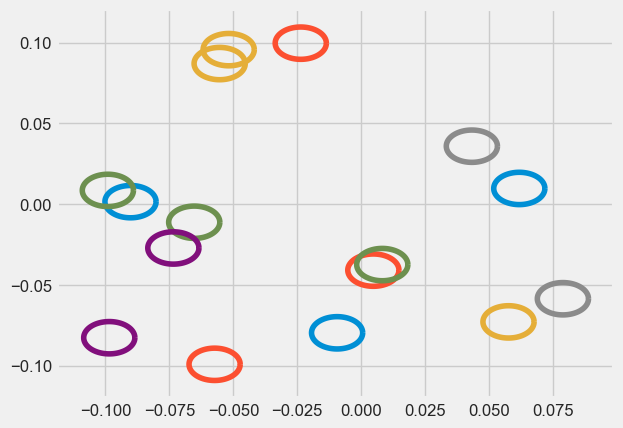

In [61]:
from IPython import display
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pylab as pl

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul((sigma_inv), torch.transpose((sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = ellipse_module.Ellipse(sigma,mu,1)
ellipse_points = ellipse.compute_confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)


def compute_distibution(d2):
    q_num = (1 + d2).pow_(-1)
    q_den = (1 + d2).pow_(-1).sum(2).reshape(-1,1,1)
    q = torch.div(q_num, q_den)
    p_num = torch.div(torch.pow(q, 2), torch.sum(q, 0))
    p_den = torch.sum(torch.div(torch.pow(q, 2), torch.sum(q, 0)),-1).reshape(-1,1,1)
    p = torch.div(p_num, p_den)
    return p

In [62]:
import torch
import numpy as np

def train(dataloader, loss_name, epoch):
    model.train()
    loss_sum = 0
    x_ant = np.empty((0,1,par_latent_dim))    
    
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
  
        if torch.isnan(x).any() == True:           
            print("ERROR training input data!")
        if torch.isnan(y).any() == True:           
            print("ERROR training output data!!")

        out, x_recon = model(x)
        
        if torch.isnan(out).any() == True:           
            print("ERROR Output!")
        if torch.isnan(x_recon).any() == True:           
            print("ERROR Decoder!")

        mu_target = torch.einsum('ij->ji',model.evolve.compute_centers(model.z))
        loss = torch.zeros(1).to(device)
        loss_kmeans = loss_fun_Kmeans(model.z, model.evolve.mu.detach())
        if torch.isnan(loss_kmeans) == True:           
            print("ERROR loss!")
        loss_FCM = loss_fun_FCM(model.z, model.evolve.mu, model.evolve.sigma_inv)

        loss_recon = loss_fun_recon(x_recon.reshape(batch_size, 1,-1), x[:,:,0].unsqueeze(1))
        loss_con = loss_fun_con(out.reshape(batch_size, par_output_dim,-1), y.reshape(batch_size, par_output_dim,-1))

        if loss_name == 'all':
            loss_ballance = loss_fun_balance(torch.nn.functional.log_softmax(torch.mean(model.evolve.compute_psi(model.z),dim = 0),dim = 1),
                                             torch.nn.functional.log_softmax(1/par_num_clusters*torch.ones(1,par_num_clusters),dim=1).to(device))
            loss_overlap = loss_fun_overlap(model.evolve.mu, model.evolve.sigma_inv.detach())
            loss = loss  + loss_con*1e4 + loss_FCM*1e3 + loss_overlap + loss_ballance

        # Compute L2 regularization term
        l2_reg = torch.tensor(0.0).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)

        # Add L2 regularization to the loss
        #loss = loss 

        loss_sum = loss_sum + loss.item()  
        if torch.isnan(loss) == True:           
            print("ERROR loss!")

        x_ant = np.append(x_ant, model.z.detach().cpu().numpy(),axis=0)
        optimizer.zero_grad()
        loss.backward()
        if torch.isnan(loss) == True:           
            print("ERROR loss!")
        optimizer.step()

        if torch.any(torch.isnan(model.evolve.mu)) == True:  
            print("ERROR mu!")

        
        if (batch == np.floor(len(dataloader)/2)):
            checks_module.check_gradient_health(model)
            clear_output(wait=True)
            
            display_module.visualize_llm(model.evolve.y_LLM, epoch)
            display_module.visualize_inputs(model.u, epoch, 'train')

            print(f"Train loss: {loss_sum:>7f}")
            x = x[:, :, 0].detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            out = out[:, 0, :].detach().cpu().numpy()

            time_indices_x = range(x.shape[1])
            time_indices_y = range(x.shape[1], x.shape[1] + y.shape[1])
            time_indices_y_all = range(x.shape[1]-par_order, x.shape[1] + y.shape[1])

            plt.figure(figsize=(10, 5))
            plt.plot(time_indices_x, x[-1], label='x (0th channel)')
            plt.plot(time_indices_y, y[-1], label='y')
            plt.plot(time_indices_y, out[-1], label='y hat')
            plt.plot(time_indices_y_all, model.evolve.y_LLM_all[-1, 0, :].detach().cpu().numpy(), label='y hat')
            plt.legend()
            plt.title('Time Series Data')

            display_module.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
            display_module.display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy(), epoch, 'train')

            display_module.visualize_attention_weights(model.att_weights.detach().cpu(), epoch)
            plt.show() 
            
    return loss_sum, x_ant



'''
model.evolve.mu.grad
model.evolve.sigma_inv.grad
model.evolve.msa.in_proj_weight.grad
model.evolve.msa.in_proj_bias.grad
model.evolve.msa.out_proj.weight.grad
model.evolve.msa.out_proj.bias.grad
model.evolve.fc_ant.weight.grad
model.evolve.fc_ant.bias.grad
model.evolve.fc_con.weight.grad
model.evolve.fc_con.bias.grad
model.evolve.fc_emb.weight.grad
model.evolve.fc_emb.bias.grad
model.evolve.input_layer_norm.weight.grad
model.evolve.input_layer_norm.bias.grad
model.evolve.ant_norm.weight.grad
model.evolve.ant_norm.bias.grad
'''

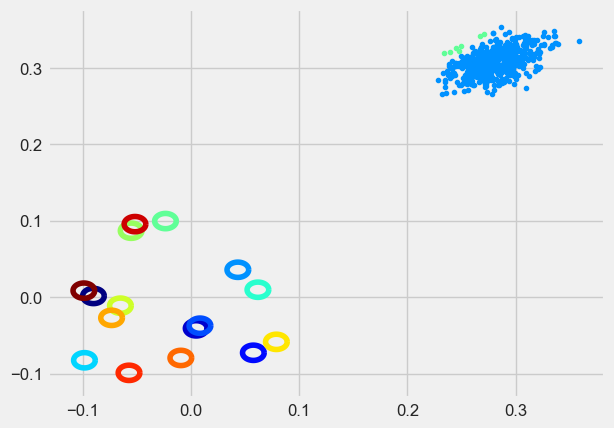

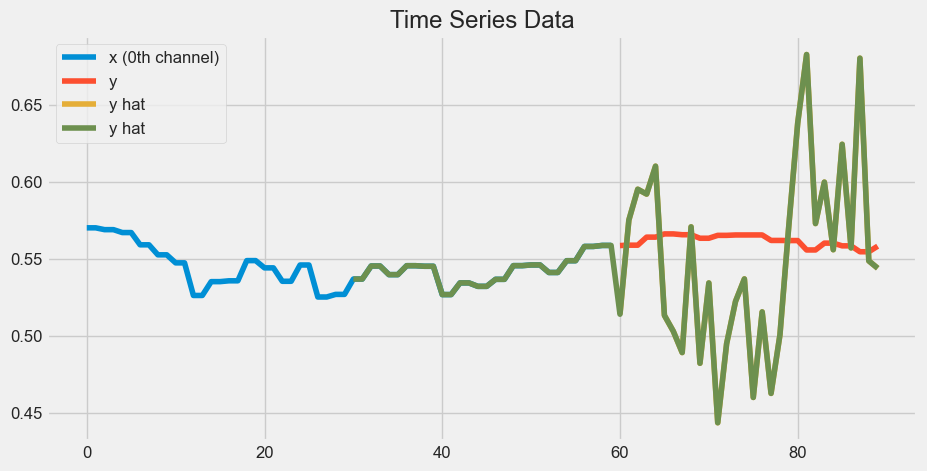

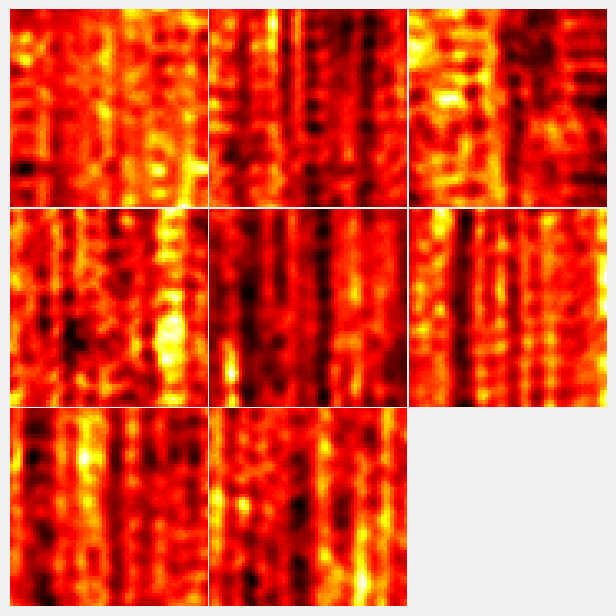

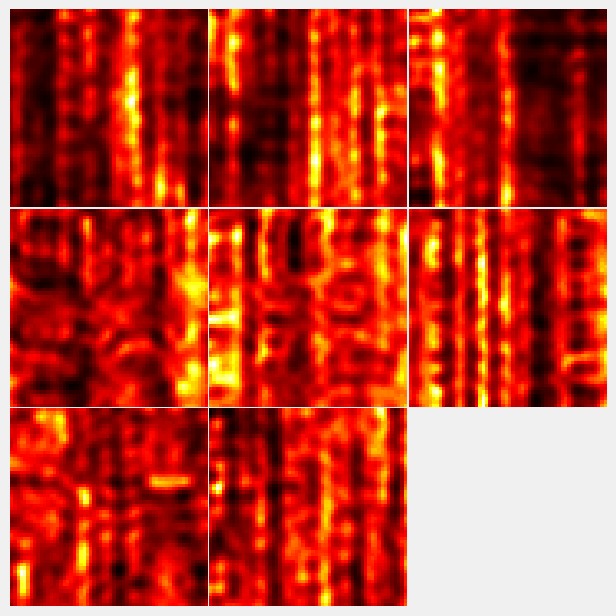

Test loss: 0.121850


In [63]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def test(dataloader,epoch):
    loss_sum = 0

    # Turn off gradients for testing, saves memory and computations
    with torch.no_grad():
        for batch, (x,y) in enumerate(dataloader):
                
                print(f"Testing")
                x = x.to(device)
                y = y.to(device)
                out, x_recon = model(x)
                loss = loss_fun_con(out.reshape(batch_size, par_output_dim, -1), y.reshape(batch_size, par_output_dim, -1))
                loss_sum = loss_sum + loss.item()
                # Clear the console
                clear_output(wait=True)

                # Display clustering and membership
                display_module.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
                display_module.display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy(),epoch,'test')

                # Extract the first channel from x and reshape the tensors
                x = x[:, :, 0].detach().cpu().numpy()
                #x_recon = x_recon[:, 0, :].cpu().numpy()
                y = y.detach().cpu().numpy()
                out = out[:, 0, :].detach().cpu().numpy()

                # Create time indices for the data
                time_indices_x = range(x.shape[1])
                time_indices_y = range(x.shape[1], x.shape[1] + y.shape[1])
                time_indices_y_all = range(x.shape[1]-par_order, x.shape[1] + y.shape[1])

                # Plot x (0th channel) and x_recon
                plt.figure(figsize=(10, 5))
                plt.plot(time_indices_x, x[-1], label='x (0th channel)')
                #plt.plot(time_indices_x, x_recon[0], label='x_recon')

                # Plot y and out
                plt.plot(time_indices_y, y[-1], label='y')
                plt.plot(time_indices_y, out[-1], label='y hat')
                plt.plot(time_indices_y_all, model.evolve.y_LLM_all[-1, 0, :].detach().cpu().numpy(), label='y hat')
                plt.legend()
                plt.title('Time Series Data')
                plt.show()

                display_module.visualize_attention_weights(model.att_weights.detach().cpu(),epoch)
                plt.show() 
            
        print(f"Test loss: {loss_sum:>7f}")

    return loss_sum

loss_test = test(test_dataloader,0)


for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

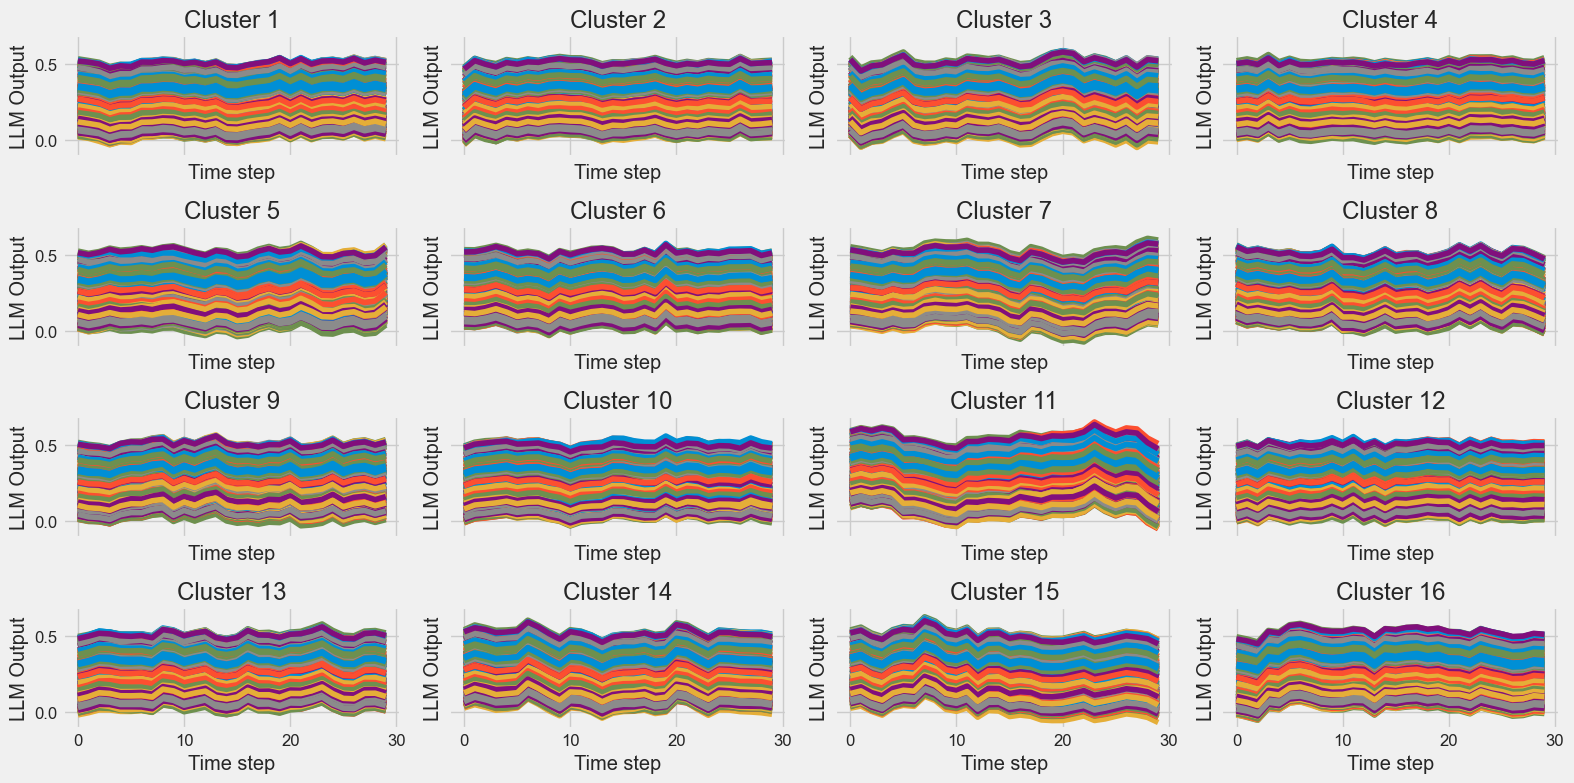

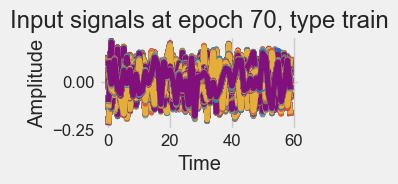

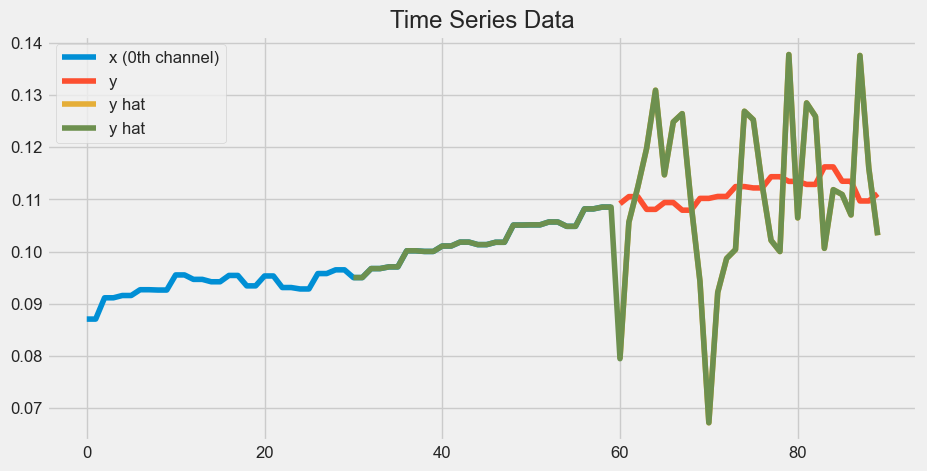

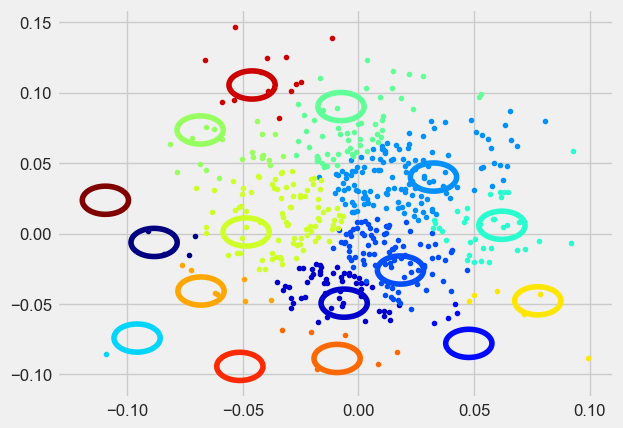

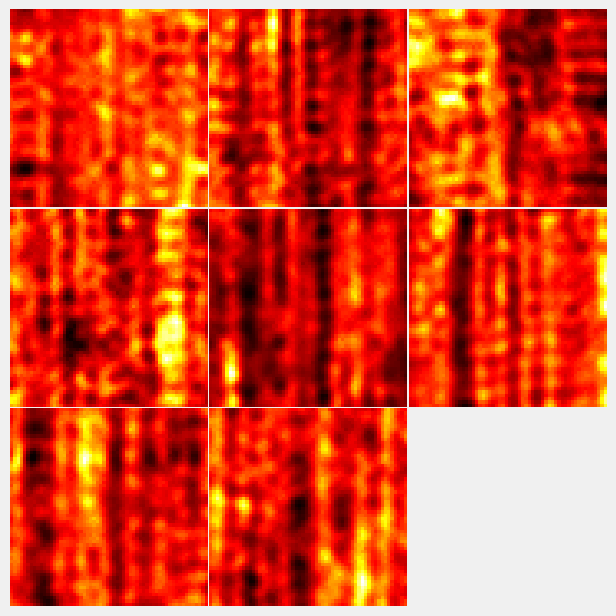

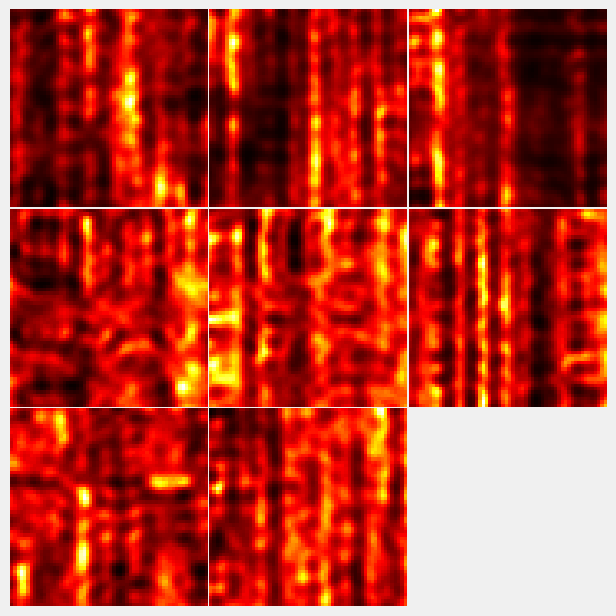

Epoch 71 - all
Gradient health for spatial_attention.linear.bias: Max abs val 3.725290298461914e-09, Avg abs val 3.725290298461914e-09, All finite values True
Gradient health for MSAs_ant.att_layers.0.fc_key.bias: Max abs val 3.8743019104003906e-07, Avg abs val 8.932693162932992e-08, All finite values True
Gradient health for MSAs_ant.att_layers.1.fc_key.bias: Max abs val 5.364418029785156e-07, Avg abs val 1.2808595784008503e-07, All finite values True
Gradient health for evolve.fc_con_layers.10.linear.weight: Max abs val 0.0, Avg abs val 0.0, All finite values True
Gradient health for evolve.fc_con_layers.12.linear.weight: Max abs val 0.0, Avg abs val 0.0, All finite values True


In [64]:
%matplotlib inline
best_model = float('inf')
#plt.ioff()
train_iterations = 100
batch_size = training_batch_size
for i in range(train_iterations):

    for p in model.parameters():
        p.requires_grad = True 

    loss_name = "all"
    lr = 1e-5
          
    epochs = 100
    model.evolve.min_clump = 0.1
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
        
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name,epoch)
        if (np.mod(epoch,10) == 1): 
            #display_module.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
            #display_module.display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
            #display_module.display_attention(model.att_weights[0,:,:].detach().cpu().numpy())
            
            #plt.plot(torch.mean(model.att_weights[0,:,:],0).detach().cpu().numpy())
            loss_test = test(test_dataloader,epoch)
            if (best_model > loss_test):
                best_model = loss_test
                torch.save(model, "model_evolve_cluster.pt")
                print(f"Save model loss: {loss_test} - ")
            #display_module.visualize_attention_weights(model.att_weights.detach().cpu(),epoch)

In [ ]:
'''
loss_test = test(test_dataloader)
if (best_model > loss_train_encoder):
    best_model = loss_train_encoder
    torch.save(model, "model_evolve_cluster_07_24.pt")
'''

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        #hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:
from torchinfo import summary
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#print(model.evolve.fc_con.bias)
#print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])
model = torch.load("model_evolve_cluster.pt", map_location=torch.device(device))

summary(model, input_size=(2, par_input_length, par_input_channels))
#model.load_state_dict(torch.load("model_evolve_cluster.pt"))

#model.eval()


In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [ ]:
history -g


In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''